In [27]:
pip install datasets

In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset


# Load dataset
data = pd.read_csv("bbc_text_cls.csv") # Replace with the actual dataset path
data = data[['text', 'labels']]         # Ensure "labels" column name is accurate


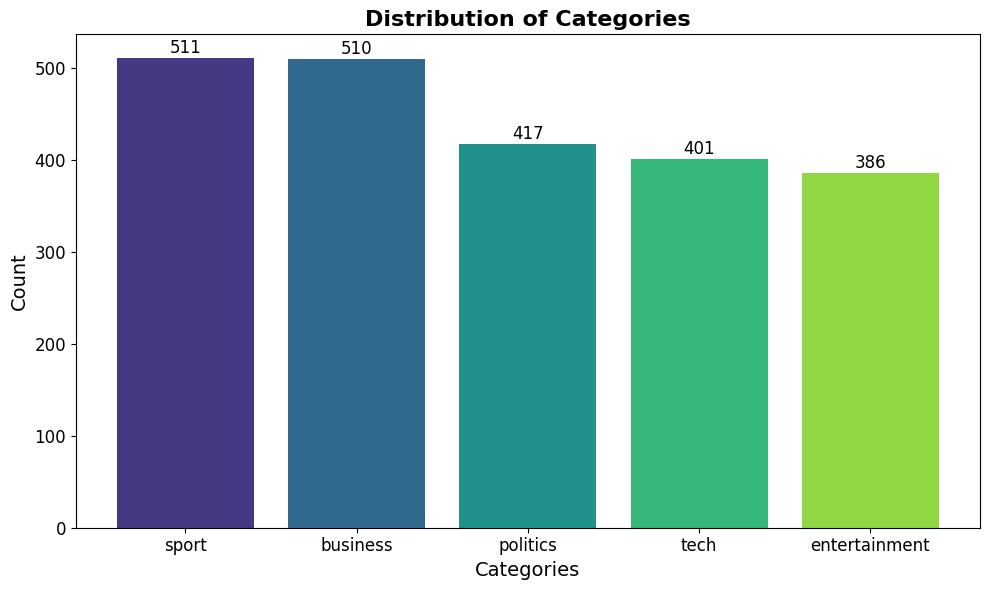

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the label-to-category mapping
label_mapping = {
    0: "Business",
    1: "Entertainment",
    2: "Politics",
    3: "Sport",
    4: "Tech"
}

# Assuming `data` is your DataFrame containing the numeric labels in 'label' column
# Map numeric labels to category names
data['category'] = data['labels'].replace(label_mapping)

# Calculate the count of each category
label_counts = data['category'].value_counts()

# Enhanced bar chart using Matplotlib
plt.figure(figsize=(10, 6))
bars = plt.bar(label_counts.index, label_counts.values, color=sns.color_palette("viridis", len(label_counts)))

# Add value annotations above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom', fontsize=12)

# Customize the chart
plt.xlabel("Categories", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Distribution of Categories", fontsize=16, fontweight="bold")
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()


In [30]:
# Encode labels to numerical values
data['label'] = data['labels'].astype('category').cat.codes

# Step 1: Split into training and test sets (80-20 split) - test set is set aside for final evaluation
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42,stratify=data['label'])

# Step 2: Further split train_data into training and validation sets (80-20 split of training data)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_data['text'], train_data['label'], test_size=0.2, random_state=42, stratify=train_data['label']
)

# Step 3: Convert to Hugging Face Dataset format
train_data = Dataset.from_dict({'text': train_texts, 'label': train_labels})
val_data = Dataset.from_dict({'text': val_texts, 'label': val_labels})
test_data = Dataset.from_dict({'text': test_data['text'], 'label': test_data['label']})

In [31]:
from transformers import DistilBertTokenizer

# Load DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize function
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True, max_length=128)


# Tokenize datasets
train_data = train_data.map(tokenize_function, batched=True)
val_data = val_data.map(tokenize_function, batched=True)
test_data = test_data.map(tokenize_function, batched=True)

# Set the format for PyTorch
train_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])



Map:   0%|          | 0/1424 [00:00<?, ? examples/s]

Map:   0%|          | 0/356 [00:00<?, ? examples/s]

Map:   0%|          | 0/445 [00:00<?, ? examples/s]

In [32]:
from transformers import DistilBertForSequenceClassification

# Load DistilBERT model for classification with 5 labels
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)

# Freeze all DistilBERT layers except the classification head
for param in model.distilbert.parameters():
    param.requires_grad = False


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
# Define metrics function with scalar conversion
from sklearn.metrics import precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Calculate per-class metrics
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average=None)

    # Print per-class metrics
    for i in range(len(precision)):
        print(f"Class {i} - Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1: {f1[i]:.4f}")

    # Calculate average metrics for logging
    avg_precision = sum(precision) / len(precision)
    avg_recall = sum(recall) / len(recall)
    avg_f1 = sum(f1) / len(f1)

    # Return average metrics for logging
    return {
        'precision': avg_precision,
        'recall': avg_recall,
        'f1': avg_f1
    }

# Set training arguments
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",        # Evaluate model every epoch
    save_strategy="epoch",              # Save model every epoch
    logging_strategy="epoch",           # Log metrics every epoch
    per_device_train_batch_size=16,     # Adjust batch size as needed
    per_device_eval_batch_size=64,      # Evaluation batch size
    num_train_epochs=30,                # Maximum number of epochs
    save_total_limit=2,                 # Limit total saved models
    load_best_model_at_end=True,        # Load the best model at the end of training
    metric_for_best_model="eval_f1",    # Use F1 as the evaluation metric
    greater_is_better=True,             # Higher F1 is better
    logging_dir='./logs',
    learning_rate=5e-5,
    report_to="none"                    # Suppress default logging to external platforms
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [34]:
# Initialize and train the Trainer
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments
from transformers import Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)])

In [35]:
# Train the model
trainer.train()

# Evaluate the model
test_results = trainer.evaluate(test_data)
print("Test Set Evaluation:", test_results)


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,1.390600,1.142759,0.906817,0.849452,0.858851
2,0.944400,0.739522,0.944593,0.924695,0.930341
3,0.603300,0.473422,0.958824,0.956637,0.957588
4,0.405100,0.339111,0.948384,0.951479,0.949549
5,0.293400,0.258226,0.956863,0.954299,0.955212
6,0.236400,0.217510,0.949358,0.950107,0.949596


Class 0 - Precision: 0.6864, Recall: 0.9878, F1: 0.8100
Class 1 - Precision: 0.9787, Recall: 0.7419, F1: 0.8440
Class 2 - Precision: 0.9841, Recall: 0.9394, F1: 0.9612
Class 3 - Precision: 0.9111, Recall: 1.0000, F1: 0.9535
Class 4 - Precision: 0.9737, Recall: 0.5781, F1: 0.7255
Class 0 - Precision: 0.7980, Recall: 0.9634, F1: 0.8729
Class 1 - Precision: 0.9833, Recall: 0.9516, F1: 0.9672
Class 2 - Precision: 0.9538, Recall: 0.9394, F1: 0.9466
Class 3 - Precision: 0.9878, Recall: 0.9878, F1: 0.9878
Class 4 - Precision: 1.0000, Recall: 0.7812, F1: 0.8772
Class 0 - Precision: 0.9167, Recall: 0.9390, F1: 0.9277
Class 1 - Precision: 0.9677, Recall: 0.9677, F1: 0.9677
Class 2 - Precision: 0.9545, Recall: 0.9545, F1: 0.9545
Class 3 - Precision: 0.9880, Recall: 1.0000, F1: 0.9939
Class 4 - Precision: 0.9672, Recall: 0.9219, F1: 0.9440
Class 0 - Precision: 0.9342, Recall: 0.8659, F1: 0.8987
Class 1 - Precision: 0.9683, Recall: 0.9839, F1: 0.9760
Class 2 - Precision: 0.9130, Recall: 0.9545, F1:

Class 0 - Precision: 0.9412, Recall: 0.9412, F1: 0.9412
Class 1 - Precision: 0.9868, Recall: 0.9740, F1: 0.9804
Class 2 - Precision: 0.9310, Recall: 0.9643, F1: 0.9474
Class 3 - Precision: 0.9709, Recall: 0.9804, F1: 0.9756
Class 4 - Precision: 0.9870, Recall: 0.9500, F1: 0.9682
Test Set Evaluation: {'eval_loss': 0.4489331543445587, 'eval_precision': 0.9633879664061535, 'eval_recall': 0.9619760631525338, 'eval_f1': 0.9625399341686421, 'eval_runtime': 0.3503, 'eval_samples_per_second': 1270.403, 'eval_steps_per_second': 19.984, 'epoch': 6.0}


In [36]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate predictions
predictions = trainer.predict(test_data)
pred_labels = predictions.predictions.argmax(-1)
true_labels = predictions.label_ids

# Print classification report
class_labels = ['business', 'entertainment', 'politics', 'sport', 'tech']
print("\nClassification Report:\n", classification_report(true_labels, pred_labels,target_names=class_labels))


Class 0 - Precision: 0.9412, Recall: 0.9412, F1: 0.9412
Class 1 - Precision: 0.9868, Recall: 0.9740, F1: 0.9804
Class 2 - Precision: 0.9310, Recall: 0.9643, F1: 0.9474
Class 3 - Precision: 0.9709, Recall: 0.9804, F1: 0.9756
Class 4 - Precision: 0.9870, Recall: 0.9500, F1: 0.9682

Classification Report:
                precision    recall  f1-score   support

     business       0.94      0.94      0.94       102
entertainment       0.99      0.97      0.98        77
     politics       0.93      0.96      0.95        84
        sport       0.97      0.98      0.98       102
         tech       0.99      0.95      0.97        80

     accuracy                           0.96       445
    macro avg       0.96      0.96      0.96       445
 weighted avg       0.96      0.96      0.96       445



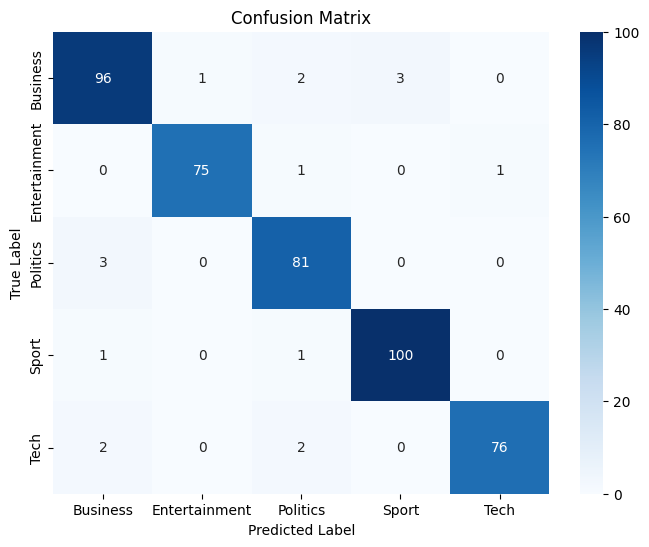

In [37]:
def plot_confusion_matrix(true_labels, pred_labels, classes):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Define class names based on your labels
class_names = ['Business', 'Entertainment', 'Politics', 'Sport', 'Tech']
plot_confusion_matrix(true_labels, pred_labels, classes=class_names)


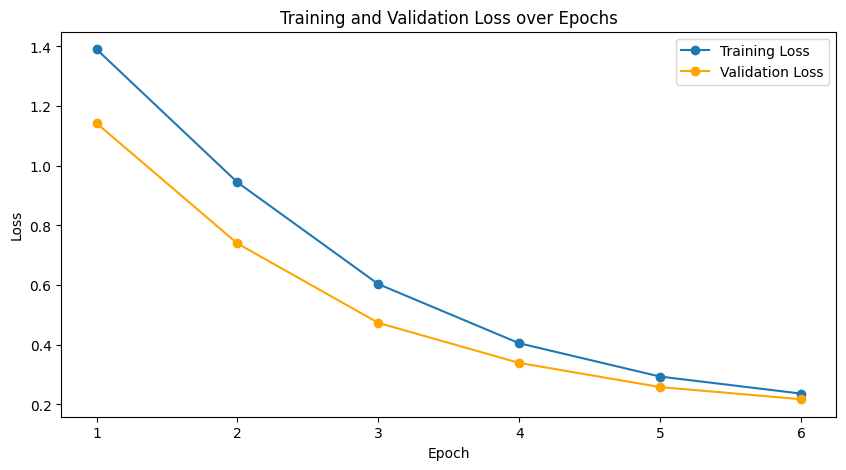

In [38]:
import matplotlib.pyplot as plt

# Initialize lists to store epoch-wise metrics
epochs = []
train_loss = []
val_loss = []
val_f1 = []
train_f1 = []

# Extract metrics from the trainer's log history
for log in trainer.state.log_history:
    if 'epoch' in log:
        current_epoch = log['epoch']
        if 'loss' in log:
            train_loss.append(log['loss'])
            epochs.append(current_epoch)
        if 'eval_loss' in log:
            val_loss.append(log['eval_loss'])
        if 'eval_f1' in log:
            val_f1.append(log['eval_f1'])

# Align lengths by truncating to the shortest list length
min_len = min(len(epochs), len(train_loss), len(val_loss), len(val_f1))
epochs = epochs[:min_len]
train_loss = train_loss[:min_len]
val_loss = val_loss[:min_len]
val_f1 = val_f1[:min_len]

# Plot Training and Validation Loss over Epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, marker='o', label="Training Loss")
plt.plot(epochs, val_loss, marker='o', color='orange', label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.show()


<ipython-input-39-1d3599f17167>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


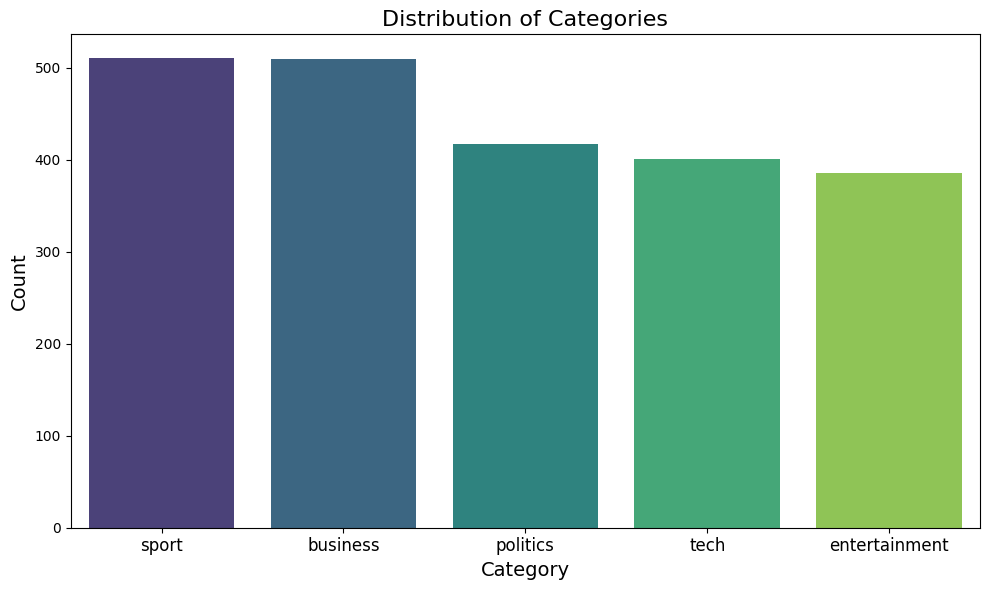

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
data = pd.read_csv("bbc_text_cls.csv")  # Replace with the correct path to your dataset

# Map numeric labels to category names if needed
label_mapping = {0: "Business", 1: "Entertainment", 2: "Politics", 3: "Sport", 4: "Tech"}
data['category'] = data['labels'].replace(label_mapping)

# Count categories
label_counts = data['category'].value_counts()

# Plot bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title("Distribution of Categories", fontsize=16)
plt.xlabel("Category", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(fontsize=12)
plt.tight_layout()
plt.show()


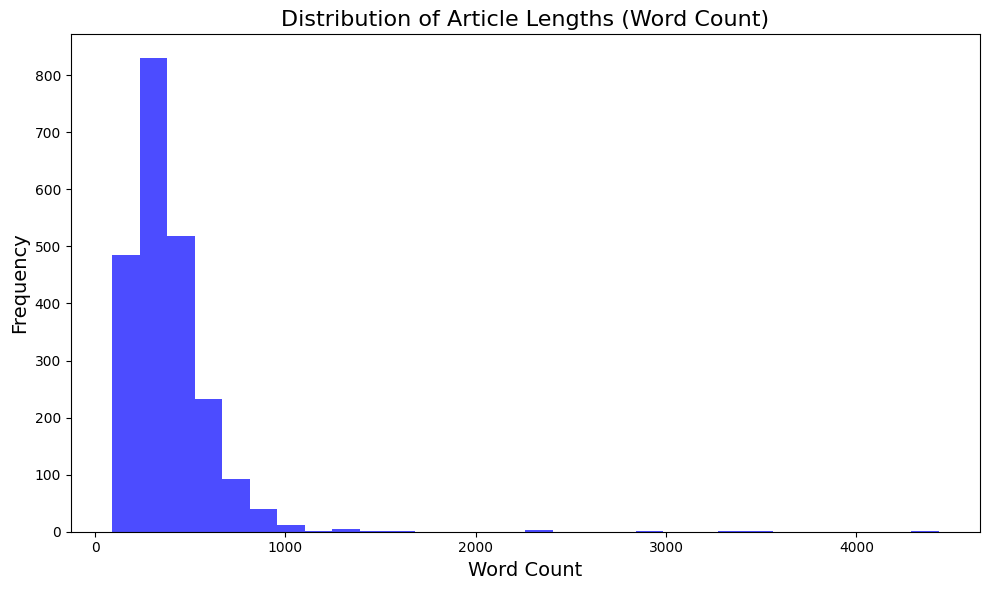

In [40]:
# Calculate text lengths
data['text_length'] = data['text'].apply(lambda x: len(x.split()))

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(data['text_length'], bins=30, color='blue', alpha=0.7)
plt.title("Distribution of Article Lengths (Word Count)", fontsize=16)
plt.xlabel("Word Count", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.tight_layout()
plt.show()


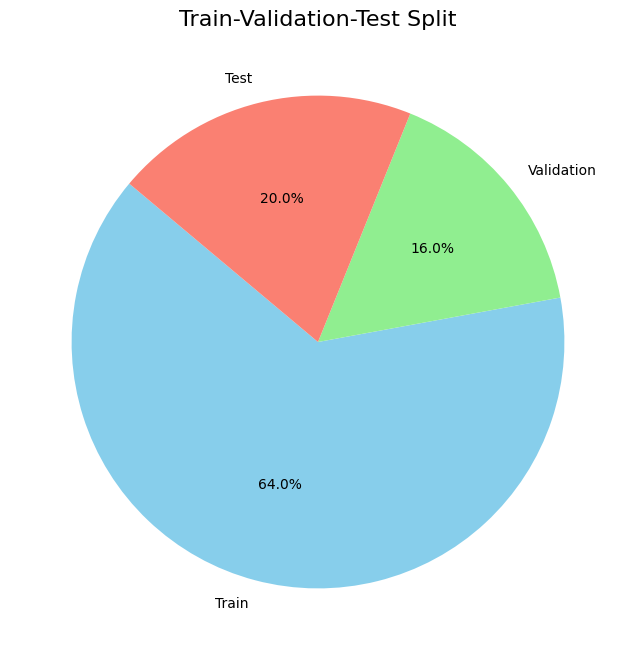

In [41]:
from sklearn.model_selection import train_test_split

# Split the dataset
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['category'], random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=train_data['category'], random_state=42)

# Sizes for pie chart
sizes = [len(train_data), len(val_data), len(test_data)]
labels = ["Train", "Validation", "Test"]

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgreen', 'salmon'])
plt.title("Train-Validation-Test Split", fontsize=16)
plt.show()


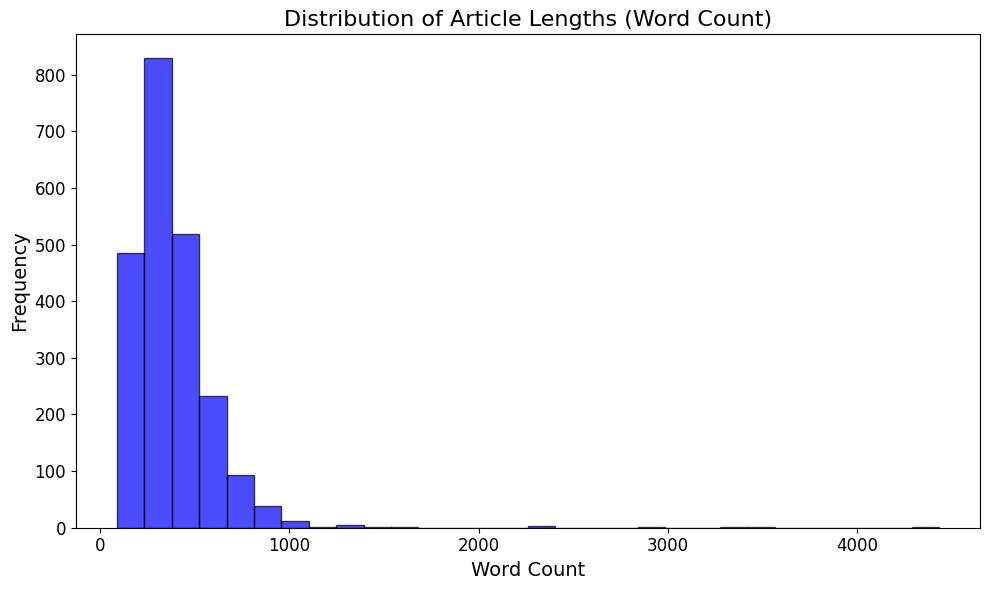

In [42]:
# Calculate text lengths
data['text_length'] = data['text'].apply(lambda x: len(x.split()))

# Plot histogram with adjusted range and bins
plt.figure(figsize=(10, 6))
plt.hist(data['text_length'], bins=30, range=(data['text_length'].min(), data['text_length'].max()),
         color='blue', alpha=0.7, edgecolor='black')
plt.title("Distribution of Article Lengths (Word Count)", fontsize=16)
plt.xlabel("Word Count", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()



In [43]:
data.shape

(2225, 4)

<ipython-input-44-07e54f3a2887>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=label_counts.index, y=label_counts.values, palette=colors)


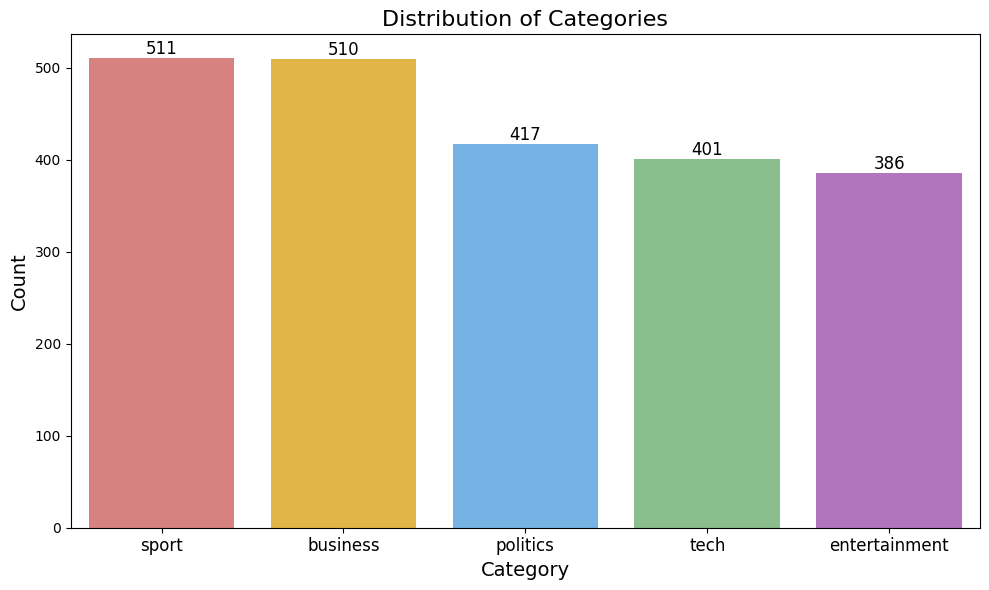

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
data = pd.read_csv("bbc_text_cls.csv")  # Replace with the correct path to your dataset

# Map numeric labels to category names if needed
label_mapping = {0: "Business", 1: "Entertainment", 2: "Politics", 3: "Sport", 4: "Tech"}
data['category'] = data['labels'].replace(label_mapping)

# Count categories
label_counts = data['category'].value_counts()

# Define medium-tone colors for each category
colors = ["#E57373", "#FBC02D", "#64B5F6", "#81C784", "#BA68C8"]  # Softer shades

# Plot bar chart
plt.figure(figsize=(10, 6))
bars = sns.barplot(x=label_counts.index, y=label_counts.values, palette=colors)
plt.title("Distribution of Categories", fontsize=16)
plt.xlabel("Category", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(fontsize=12)

# Add labels above each bar
for bar in bars.patches:
    bar_height = bar.get_height()
    bars.annotate(f"{int(bar_height)}",
                  (bar.get_x() + bar.get_width() / 2, bar_height),
                  ha='center', va='bottom', fontsize=12, color='black')

plt.tight_layout()
plt.show()


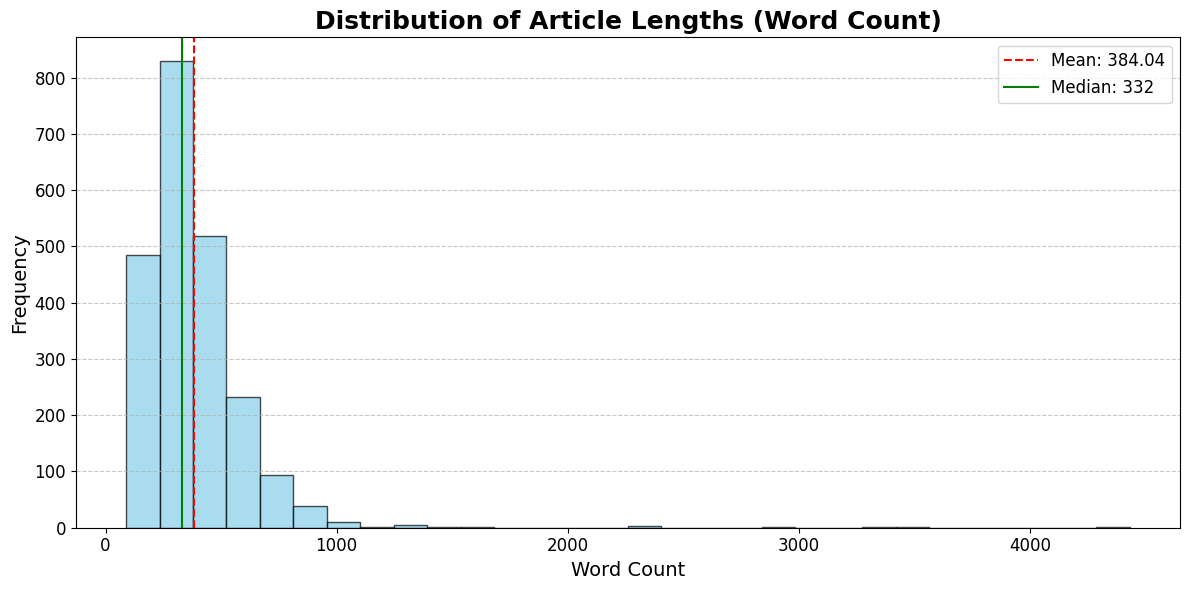

In [45]:
# Calculate text lengths
data['text_length'] = data['text'].apply(lambda x: len(x.split()))

# Calculate statistics
mean_length = data['text_length'].mean()
median_length = data['text_length'].median()

# Plot histogram
plt.figure(figsize=(12, 6))
plt.hist(data['text_length'], bins=30, color='skyblue', alpha=0.7, edgecolor='black')
plt.axvline(mean_length, color='red', linestyle='--', label=f'Mean: {mean_length:.2f}')
plt.axvline(median_length, color='green', linestyle='-', label=f'Median: {median_length:.0f}')

# Add gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add title and labels
plt.title("Distribution of Article Lengths (Word Count)", fontsize=18, fontweight='bold')
plt.xlabel("Word Count", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Add legend
plt.legend(fontsize=12)

# Customize ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()


In [46]:

# Confirm which parameters are trainable
for name, param in model.named_parameters():
    print(f"{name}: requires_grad = {param.requires_grad}")


distilbert.embeddings.word_embeddings.weight: requires_grad = False
distilbert.embeddings.position_embeddings.weight: requires_grad = False
distilbert.embeddings.LayerNorm.weight: requires_grad = False
distilbert.embeddings.LayerNorm.bias: requires_grad = False
distilbert.transformer.layer.0.attention.q_lin.weight: requires_grad = False
distilbert.transformer.layer.0.attention.q_lin.bias: requires_grad = False
distilbert.transformer.layer.0.attention.k_lin.weight: requires_grad = False
distilbert.transformer.layer.0.attention.k_lin.bias: requires_grad = False
distilbert.transformer.layer.0.attention.v_lin.weight: requires_grad = False
distilbert.transformer.layer.0.attention.v_lin.bias: requires_grad = False
distilbert.transformer.layer.0.attention.out_lin.weight: requires_grad = False
distilbert.transformer.layer.0.attention.out_lin.bias: requires_grad = False
distilbert.transformer.layer.0.sa_layer_norm.weight: requires_grad = False
distilbert.transformer.layer.0.sa_layer_norm.bias: 